In [1]:
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# **Load the datasets**

In [2]:
english_task_a = pd.read_csv('/kaggle/input/intended-sarcasm-detection-in-english/english_task_a.csv')
english_task_c = pd.read_csv('/kaggle/input/intended-sarcasm-detection-in-english/english_task_c.csv')
train_data = pd.read_csv('/kaggle/input/intended-sarcasm-detection-in-english/train.En.csv')

# **Select particular columns**

In [3]:
english_task_a = english_task_a[['text', 'sarcasm_ref']]
english_task_c_text_1 = english_task_c[['text_1','sarcastic_id_ref']]
english_task_c_text_0 = english_task_c[['text_0','sarcastic_id_ref']]
train_data_1 = train_data[['tweet', 'sarcastic']]
train_data_2 = train_data[['rephrase', 'sarcasm']]

In [4]:
english_task_a.columns = ['text', 'sarcasm']
english_task_c_text_1.columns = ['text','sarcasm']
english_task_c_text_0.columns = ['text','sarcasm']
train_data_1.columns = ['text', 'sarcasm']
train_data_2.columns = ['text', 'sarcasm']

# **Combine data**

In [5]:
combined_data = pd.concat([english_task_a,english_task_c_text_1,english_task_c_text_0,train_data_1,train_data_2], axis=0)
print(combined_data.shape)
# Remove any rows with NaN values in the 'text' and 'sarcasm' columns
combined_data.dropna(subset=['text', 'sarcasm'], inplace=True)
print(combined_data.shape)
# Reset the index after concatenation
combined_data.reset_index(drop=True, inplace=True)
print(combined_data.shape)
# 'combined_data' with 'text' and 'sarcasm' columns
combined_data['sarcasm'] = combined_data['sarcasm'].astype(int)
combined_data.head()
print(combined_data.shape)

(8736, 2)
(6134, 2)
(6134, 2)
(6134, 2)


# **Step 1: Preprocessing**

In [6]:

def preprocess_data_torch(texts, labels, vocab_size=10000, seq_len=100):
    all_texts = ' '.join(texts)
    words = all_texts.split()
    counts = Counter(words)
    vocab = sorted(counts, key=counts.get, reverse=True)[:vocab_size]
    vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)}
    texts_ints = []
    for text in texts:
        texts_ints.append([vocab_to_int[word] for word in text.split() if word in vocab_to_int])
    features = np.zeros((len(texts_ints), seq_len), dtype=int)
    for i, row in enumerate(texts_ints):
        if len(row) > 0:
            features[i, -len(row):] = np.array(row)[:seq_len]
    return torch.tensor(features), torch.tensor(labels), vocab_to_int

In [7]:
from gensim.models import KeyedVectors
# Load vectors directly from the file
# Load vectors directly from the file
word2vec = KeyedVectors.load_word2vec_format('/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin', binary=True)

# Example usage with a subset of 'english_task_a.csv'
texts = combined_data["text"]  # Replace with your data
labels = combined_data["sarcasm"]  # Replace with your data
features, labels, vocab_to_int = preprocess_data_torch(texts, labels)

# Now you can calculate embedding_matrix
embedding_dim = 300  # For Google's Word2Vec model
vocab_size = len(vocab_to_int) + 1  # Plus 1 for padding

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in vocab_to_int.items():
    if word in word2vec:
        embedding_vector = word2vec[word]
        embedding_matrix[i] = embedding_vector

# **Step 2: Define the LSTM Model**

In [8]:

class SarcasmLSTM(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5, embedding_matrix=None):
        super(SarcasmLSTM, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
            self.embedding.weight.requires_grad = False  # Set to `True` if you want it to be trainable

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()

        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = self.embedding(x)
        lstm_out, hidden = self.lstm(x, hidden)
        lstm_out = lstm_out[:, -1, :]
        out = self.dropout(lstm_out)
        out = self.fc(out)
        out = self.sigmoid(out)
        return out, hidden

# **Step 3: Train the Model**

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score

def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'  # Display integers in the cells

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


def train_model(model, train_loader, valid_loader, epochs=20, clip=5):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        for inputs, labels in train_loader:
            h = (torch.zeros(2, inputs.size(0), 256), torch.zeros(2, inputs.size(0), 256))
            output, h = model(inputs, h)
            loss = criterion(output.squeeze(), labels.float())
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()

        model.eval()
        valid_losses = []
        all_preds = []
        all_labels = []
        
        for v_inputs, v_labels in valid_loader:
            v_h = (torch.zeros(2, v_inputs.size(0), 256), torch.zeros(2, v_inputs.size(0), 256))
            v_output, v_h = model(v_inputs, v_h)
            v_loss = criterion(v_output.squeeze(), v_labels.float())
            valid_losses.append(v_loss.item())
            
            preds = torch.round(v_output.squeeze()).detach().cpu().numpy()
            labels = v_labels.cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels)
            
        precision = precision_score(all_labels, all_preds)
        recall = recall_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds)  # Compute F1 score
        conf_mat = confusion_matrix(all_labels, all_preds)
        accuracy = (conf_mat[0, 0] + conf_mat[1, 1]) / np.sum(conf_mat)
        
        print(f"Epoch: {epoch+1}/{epochs}... Training Loss: {loss.item()}... Validation Loss: {np.mean(valid_losses)}")
        print(f"Precision: {precision}, Recall: {recall}")
        print(f"F1-Score: {f1}")
        print(f"Accuracy: {accuracy}")
        
    print(f"Final Confusion Matrix:\n{conf_mat}")
    plot_confusion_matrix(conf_mat, classes=['Non-Sarcastic', 'Sarcastic'])

In [10]:
texts = combined_data["text"]  # Replace with your data
labels = combined_data["sarcasm"]  # Replace with your data
features, labels, vocab_to_int = preprocess_data_torch(texts, labels)

# **Create DataLoaders**

In [11]:

train_data, val_data, train_labels, val_labels = train_test_split(features, labels, test_size=0.3)

train_data = TensorDataset(train_data, train_labels)
val_data = TensorDataset(val_data, val_labels)

from torch.utils.data import RandomSampler
train_sampler = RandomSampler(train_data)
val_sampler = RandomSampler(val_data)

train_loader = DataLoader(train_data, batch_size=50, sampler=train_sampler)
val_loader = DataLoader(val_data, batch_size=50, sampler=val_sampler)

# **Initialize the model**

In [12]:
model = SarcasmLSTM(vocab_size=vocab_size, output_size=1, embedding_dim=embedding_dim, hidden_dim=256, n_layers=2, embedding_matrix=embedding_matrix)

# **Result: Precision, Recall, accuracy, confusion matrix**

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1/20... Training Loss: 0.6511855721473694... Validation Loss: 0.628928546969955
Precision: 0.0, Recall: 0.0
F1-Score: 0.0
Accuracy: 0.6757197175448126


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2/20... Training Loss: 0.7527618408203125... Validation Loss: 0.6364834324733631
Precision: 0.0, Recall: 0.0
F1-Score: 0.0
Accuracy: 0.6757197175448126
Epoch: 3/20... Training Loss: 0.6815283298492432... Validation Loss: 0.6266951448208576
Precision: 0.45588235294117646, Recall: 0.051926298157453935
F1-Score: 0.09323308270676692
Accuracy: 0.6724606192286801
Epoch: 4/20... Training Loss: 0.6270503997802734... Validation Loss: 0.6307507801700283
Precision: 0.43157894736842106, Recall: 0.06867671691792294
F1-Score: 0.11849710982658959
Accuracy: 0.6686583378598587
Epoch: 5/20... Training Loss: 0.47482672333717346... Validation Loss: 0.6454413766796524
Precision: 0.43253968253968256, Recall: 0.18257956448911222
F1-Score: 0.2567726737338045
Accuracy: 0.6572514937533949
Epoch: 6/20... Training Loss: 0.5369815230369568... Validation Loss: 0.6640180969560469
Precision: 0.453125, Recall: 0.09715242881072027
F1-Score: 0.15999999999999998
Accuracy: 0.6692015209125475
Epoch: 7/20... Training

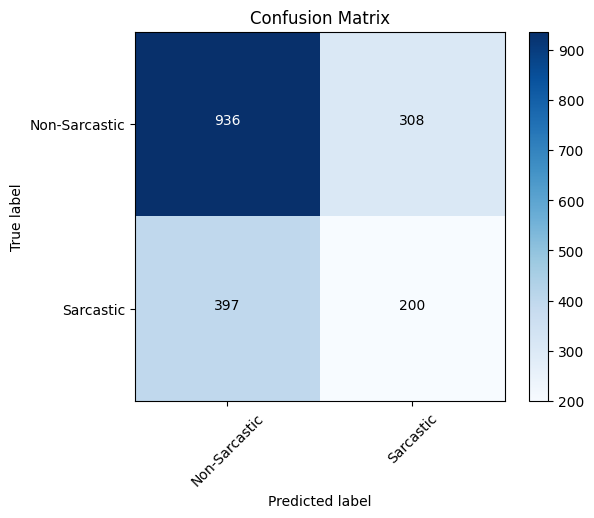

In [13]:
train_model(model, train_loader, val_loader)

In [14]:
print(f"Max token ID in features: {torch.max(features)}")
print(f"Min token ID in features: {torch.min(features)}")

Max token ID in features: 10000
Min token ID in features: 0
